In [1]:
#!/bin/python3

In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
names  =open("names.txt","r").read().splitlines()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = sorted(list(set("".join(names))))
string_int = {s:i+1 for i,s in enumerate(chars)}
string_int["."]=0
int_string = {s:i for i,s in string_int.items()}
int_string

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [5]:
#now making the trigram
block_size = 3
x,y = [],[]
for i,name in enumerate(names):
    context = [0]*block_size
    for ch in name+".":
        ix =string_int[ch]
        x.append(context)
        y.append(ix)
        if i<5:
            print("".join(int_string[i] for i in context),"--------->",int_string[ix])
        context = context[1:]+[ix]

x = torch.tensor(x)
y= torch.tensor(y)
x,y


... ---------> e
..e ---------> m
.em ---------> m
emm ---------> a
mma ---------> .
... ---------> o
..o ---------> l
.ol ---------> i
oli ---------> v
liv ---------> i
ivi ---------> a
via ---------> .
... ---------> a
..a ---------> v
.av ---------> a
ava ---------> .
... ---------> i
..i ---------> s
.is ---------> a
isa ---------> b
sab ---------> e
abe ---------> l
bel ---------> l
ell ---------> a
lla ---------> .
... ---------> s
..s ---------> o
.so ---------> p
sop ---------> h
oph ---------> i
phi ---------> a
hia ---------> .


(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         ...,
         [26, 26, 25],
         [26, 25, 26],
         [25, 26, 24]]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [6]:
x.dtype,x.shape,y.dtype,y.shape

(torch.int64, torch.Size([228146, 3]), torch.int64, torch.Size([228146]))

In [7]:
#archictecture of neural network

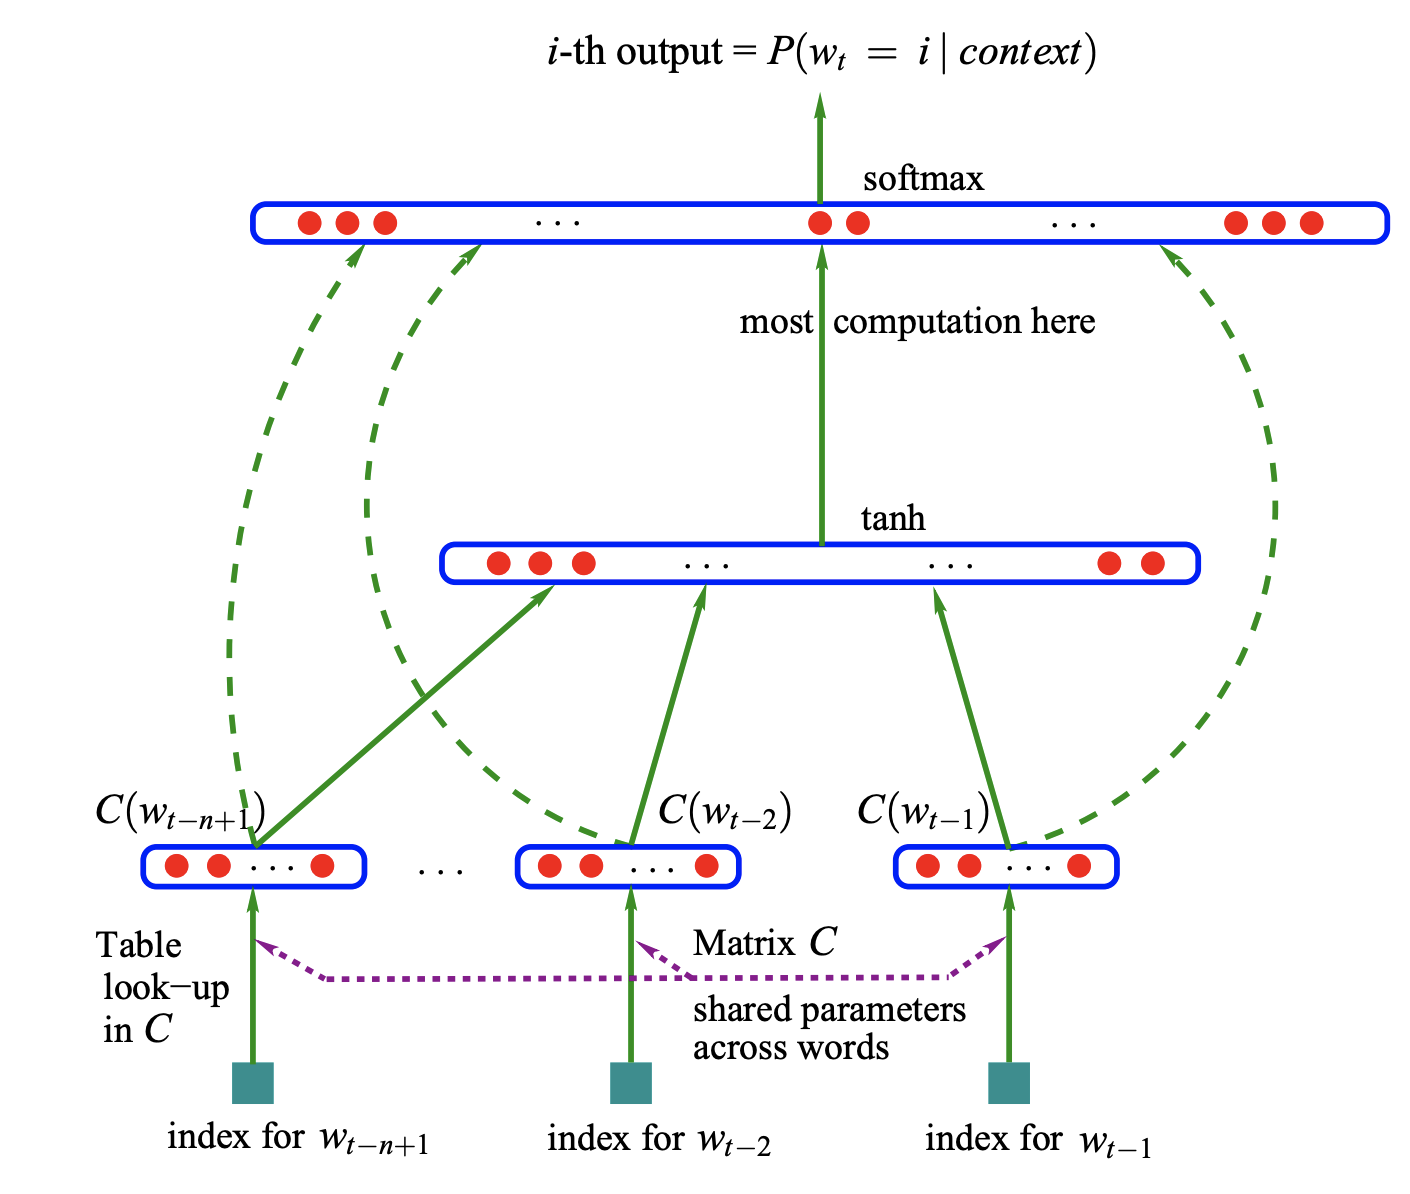

In [8]:
#_________________Now organaizing everyting in a neat manner the forward pass and the backward pass______________#

In [9]:
import torch.nn.functional as F

In [10]:
x.shape,y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [11]:
def build_database(names):
    #now making the trigram
    block_size = 3
    x,y = [],[]
    for i,name in enumerate(names):
        context = [0]*block_size
        for ch in name+".":
            ix =string_int[ch]
            x.append(context)
            y.append(ix)
            context = context[1:]+[ix]

    x = torch.tensor(x)
    y= torch.tensor(y)
    print(x.shape,y.shape)
    return x,y
import random 
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))
xtr,ytr = build_database(names[:n1])
xdev,ydev = build_database(names[n1:n2])
xte,yte = build_database(names[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [12]:
#____________________________organised makemore_______________________________#

In [13]:
vocab_size = len(int_string)
n_embd =10
n_hidden= 200

In [14]:
g = torch.Generator().manual_seed(2147483647)
C= torch.randn(vocab_size,n_embd)
W1 = torch.randn((n_embd*block_size,n_hidden),generator=g)
b1 = torch.randn(n_hidden,generator=g)
W2 = torch.randn(n_hidden,vocab_size,generator=g)*0.01# the reason ive put this 0.01 is to normalize all the weights so none of them is like crazy number like -17.324 so every thing will squash to 0.somefloat number and it'll be easy to backpropagate
b2 = torch.randn(vocab_size,generator=g)# the same is for bias
parameters = [C,W1,b1,W2,b2]

In [15]:
for p in parameters:
    p.requires_grad=True
batch_size=32
lossi = []
for _ in range(1000):
    #creating mini-batch of the data 
    ix = torch.randint(0,xtr.shape[0],(batch_size,))
    #forward pass
    emb = C[xtr[ix]]
    h_pred =emb.view(emb.shape[0],n_embd*block_size)@W1+b1
    h = torch.tanh(h_pred)
    logits = h@W2 +b2

    #backward pass
    loss = F.cross_entropy(logits,ytr[ix])
    for p in parameters:
        p.grad =None
    loss.backward()
    for p in parameters:
        p.data += -0.1*p.grad
    lossi.append(loss.log10().item())
print(f"loss : {loss.item()}")


loss : 3.041168689727783


In [16]:
#> so the prediction are all right and the loss is comming low for each batch then whats the problem
# if we look at the h before going in the activation function
h,h.shape

(tensor([[ 0.9437, -0.9842, -0.9606,  ...,  0.9972,  0.9995, -0.9990],
         [ 1.0000,  0.7849, -0.9881,  ..., -1.0000, -1.0000,  0.9997],
         [-0.9981, -0.9772, -0.9994,  ..., -0.9976, -0.9998, -0.9573],
         ...,
         [ 1.0000,  0.9995, -1.0000,  ..., -1.0000, -1.0000,  0.9996],
         [ 1.0000,  0.9961, -0.7067,  ..., -0.9812, -1.0000,  0.3744],
         [-0.8069,  0.9519, -0.9998,  ...,  0.9418,  1.0000, -0.6620]],
        grad_fn=<TanhBackward0>),
 torch.Size([32, 200]))

In [17]:
#we can see a lot of value are b/w 1 - (-1) and  1 and -1 so whats the problem right ?
# if we remember from the micrograd course the dy/dx of tanh is (1- (tanh)**2)*out.grad and since tanh becomes 1 or -1 the whole gradient of the nuron becomes 0 and the other neurons also which are connected to it  and since during backpropagration we know we use {weight = -0.01*weights/bias.grad} for upgradation of weight and biase the weight and biase also beome 0 and the whole neuron dies and some parts of the network dies    

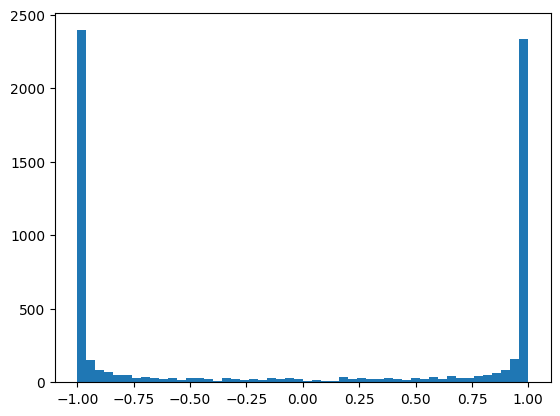

In [18]:
#and if we see the number of 1 and -1 after the activation function the result is facinating cause ther are a lot of the data is spreaded like its in -1 and 1 
plt.hist(h.view(-1).tolist(),50);
# to solve this  we want some gaussian/bell curve like distribution of the data to not led the neuron to die during backprop


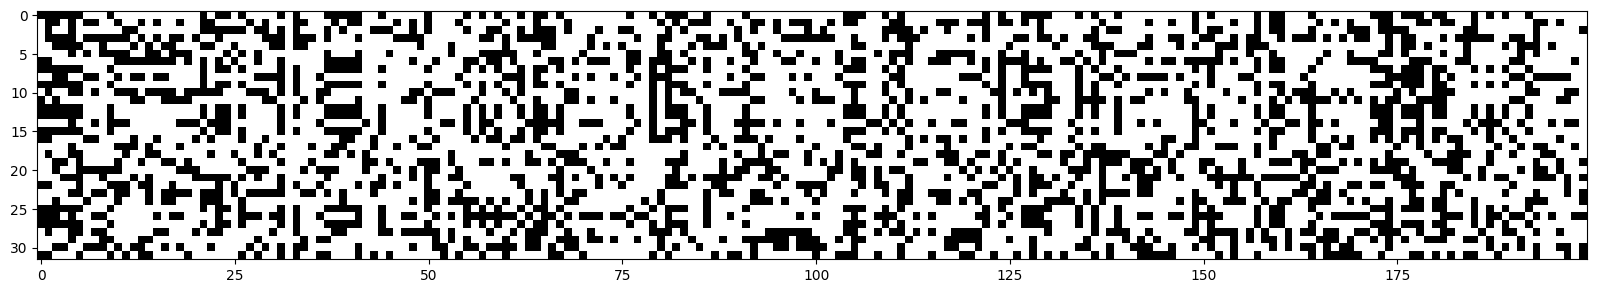

In [19]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() >0.99,cmap="gray",interpolation="nearest")
# in this all whats white means that the neuron is destroyed it is a 32x100 matrix
# Now to fix that we'll have to shrunk the h_pred more close to 0(but not 0) and then send it to the activation function to do that if we multiply the W1 with 0.01 like we did with W2 but the purpose of initialization of W1*0.1 and initialization of W1*0.1 is totally different  

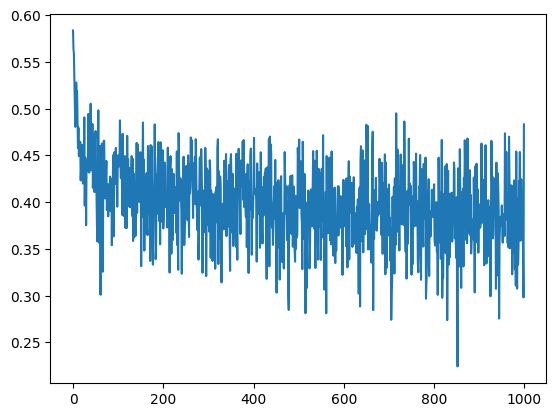

In [20]:
plt.plot(lossi)

In [21]:
#------------------------------------Understanding the shrunking part-------------------------------------------
g = torch.Generator().manual_seed(2147483647)
C= torch.randn(vocab_size,n_embd)
W1 = torch.randn((n_embd*block_size,n_hidden),generator=g)*0.01# and by *0.01 we can see the no of 1,-1s in the non-linearity/after_activation_function are way less then before 
b1 = torch.randn(n_hidden,generator=g)*0.01# the same is with bias
W2 = torch.randn(n_hidden,vocab_size,generator=g)*0.01# the reason ive put this 0.01 is to normalize all the weights so none of them is like crazy number like -17.324 so every thing will squash to 0.somefloat number and it'll be easy to backpropagate
b2 = torch.randn(vocab_size,generator=g)# the same is for bias
parameters = [C,W1,b1,W2,b2]

In [22]:
for p in parameters:
    p.requires_grad=True
batch_size=32
lossi = []
for _ in range(1000):
    #creating mini-batch of the data 
    ix = torch.randint(0,xtr.shape[0],(batch_size,))
    #forward pass
    emb = C[xtr[ix]]
    h_pred =emb.view(emb.shape[0],n_embd*block_size)@W1+b1
    h = torch.tanh(h_pred)
    logits = h@W2 +b2

    #backward pass
    loss = F.cross_entropy(logits,ytr[ix])
    for p in parameters:
        p.grad =None
    loss.backward()
    for p in parameters:
        p.data += -0.1*p.grad
    lossi.append(loss.log10().item())
print(f"loss : {loss.item()}")


loss : 2.3627750873565674


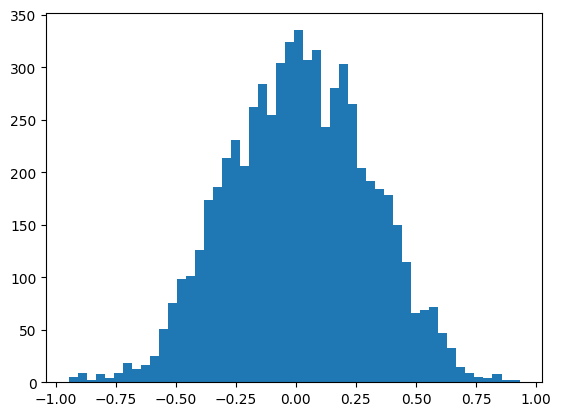

In [23]:
plt.hist(h.view(-1).tolist(),50);# the non-linearity or the after activation we can see all the 1,-1s are less then before

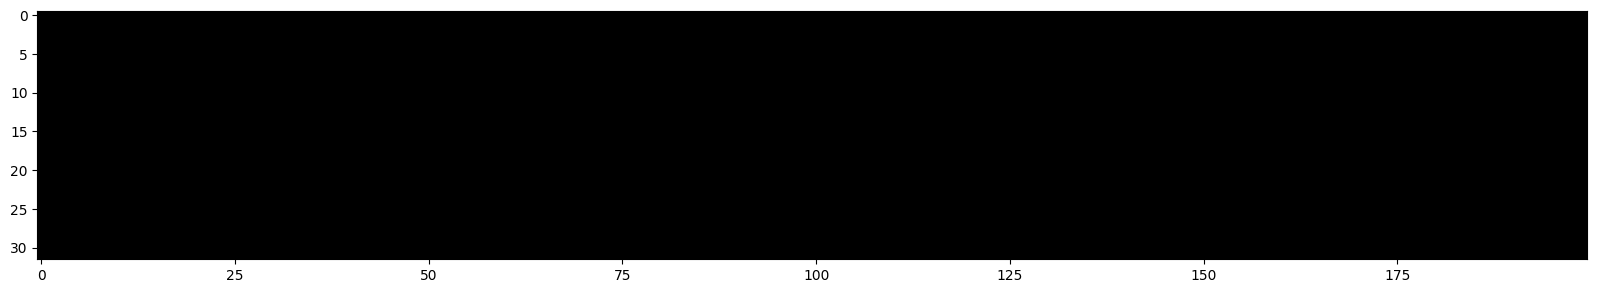

In [24]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() >0.99,cmap="gray",interpolation="nearest")# NOw as we can see the dead neurons are gone and all what we have is alive neurons 

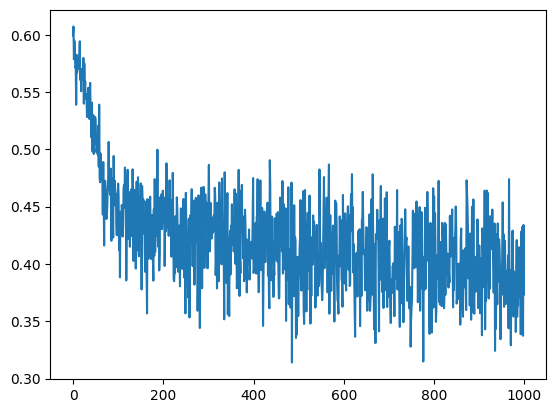

In [25]:
plt.plot(lossi)

In [26]:
# But the biggest question is and you should focus in this that how did i come up with the number 0.01 it could have been anything then how did 0.01 work
# to understand those thing there are some rules for that 
# to understand it more clearly i'll create a  linear simple temp neural network just for understanding 

tensor(0.0045) tensor(1.0056)
tensor(-0.0225) tensor(3.1169)


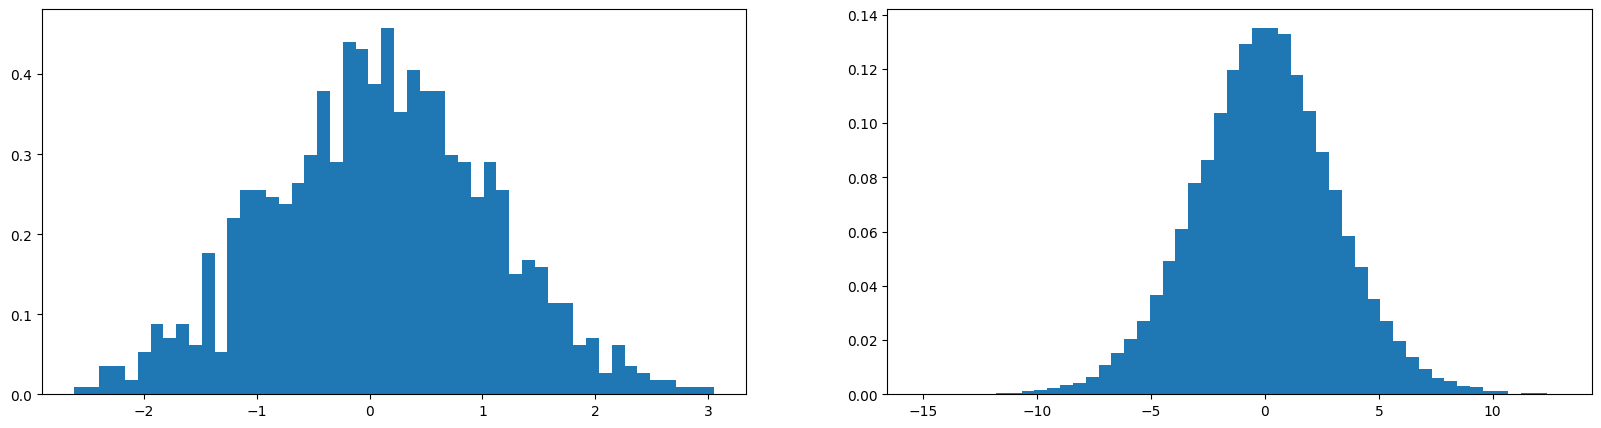

In [27]:
inp = torch.randn(100,10)#it is consist of 100 data and each data made up of 10 vector 
weight = torch.randn(10,200)#10 input and 200 neurons 
# and for this we're not using the bias just to have a clear understanding just think that the bias is 0
pre_activations = inp@weight
print(weight.mean(),weight.std())# printing the weight mean and weight standard deviation (btw if you forgot the formula of standard deviation then its  : - sum(weight/weight.mean())/len(weight) in this we dont care about he shape of the matrx to find the standard deviation we just find the whole standard deviation of the matrix )
print(pre_activations.mean(),pre_activations.std())# printing the pre_actiavtion mean and pre_activation standard deviation
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(inp.view(-1).tolist(),50,density=True,);
plt.subplot(122)
plt.hist(pre_activations.view(-1).tolist(),50,density=True);
#this is the before and after the multiplication of the weigth with inp and we can see the standard deviation has increase by 3 
# so the most common practice is to bring the standard deviation to as close as the input standard deviation or to 1 but in future we'll get to to it is not the case
# because to more far away the standard deviation is from 0 it is more likely to produce 1,-1 when it goes through the activation function so our approach is to bring it more closely to 0 in this case as you can see the inp the spread it spreaded to -4,-3 and after the weight multiplication the spread has been increased to -10,15 which we tend to decrease
# to achive that we'll have to use some techniques


tensor(0.0054) tensor(0.3166)
tensor(-0.0047) tensor(3.1169)


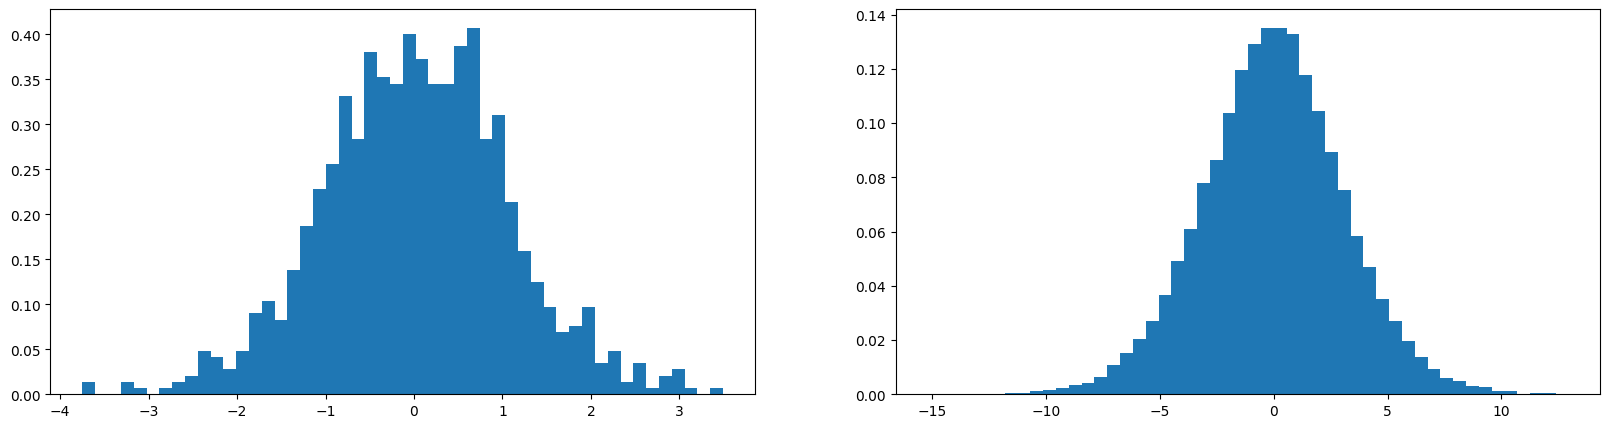

In [28]:
#and the technique is to divide it with the sqrt(inp) 
#like this :-
inp = torch.randn(100,10)
weight = torch.randn(10,200) /10**0.5
pre_activation = inp@weight
print(weight.mean(),weight.std())
print(pre_activation.mean(),pre_activations.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(inp.view(-1).tolist(),50,density=True,);
plt.subplot(122)
plt.hist(pre_activations.view(-1).tolist(),50,density=True);
# as we can see the spread has been decreased by a alot from -10,10 to -4,4 and thats a huge achivement 
#btw dont focus on the mean it dosen't matter as much as data is there 
# but the question arise how did we come up with this technique sqrt(inp) 

In [29]:
# so all these changes we are doing is to prevent non-linearity to become 0 or inf and the same is for the grad all by chnaging the initialization of the mlp's weights and biases to some distribution we're not changing any input or any method of mlp we're just simply tweaking the value of weights and biase to prevent any number to reach 0 or inf 
# to know more about how to prevent it i want to invite you to read this reasearch paper :- https://arxiv.org/pdf/1502.01852

In [30]:
#some terminologies 
# the number of weight input aka the row of weight aka the number we put in sqrt is called fan_in 
# and the number of neurons in a layer aka the column of weight is called fan_out
# but why we use sqrt()  here is the explaination
# so all this we are doing is called weight initialization there are a lot of techniques of weights initialization such as  :-
#>Xavier Normal Initialization {gain*sqrt(2/fan_in+fan_out)}(used in activation functions like sigmoid and tanh)
#>Kaiming Initialization or He Initialization {gain*sqrt(2/fan_in)}(used in activation function like for ReLU and its variants)
# in this case we use Kaiming Initialization or He Initialization but in our case its not relu so we remove 2 from the equation so whats left was sqrt(fan_in)
# Gain is a scaling factor used during weight initialization to account for the properties of different activation functions. Different activation functions can have different effects on the variance of the inputs and outputs, and the gain helps to adjust for these effects.

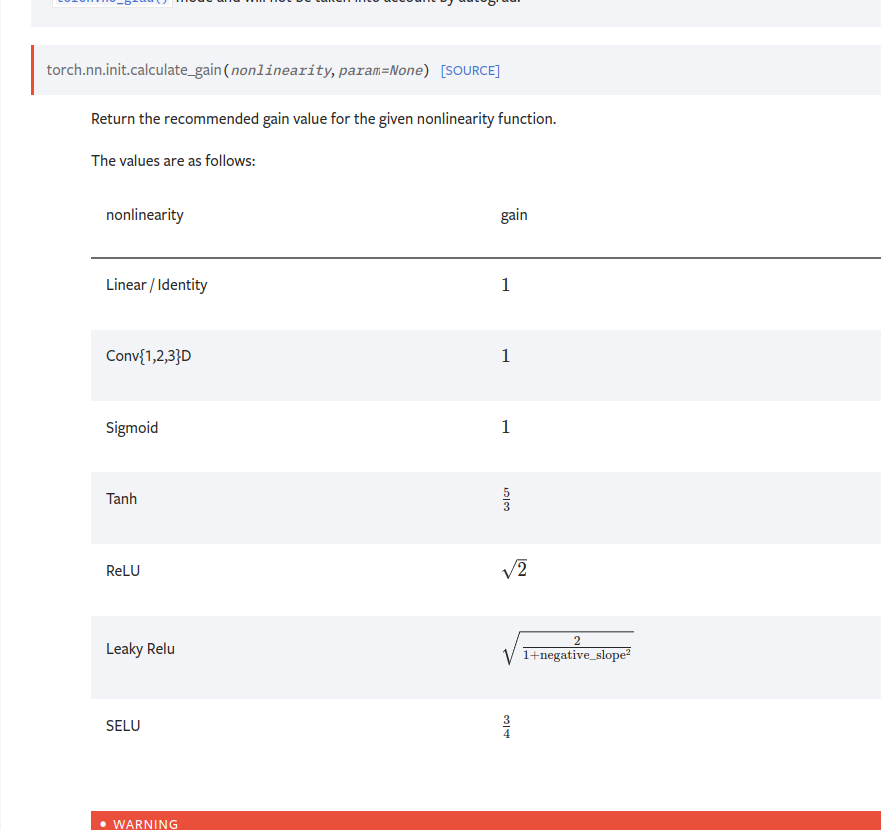

In [31]:
#one and final thing all this time ive been telling you that we have to make the pre_activation standard deviation as small as the inp standard deviation
# but in actual its not the case cause 
#we have to make the pre_activation standard deviation the same as {gain*weight initilization} which ive explained in previous cells
#so how to make it ,surprisingly its was easy because
(torch.randn(1000)*0.019).std()
# as you can see the standard deviation is same/(or can be close) as the value ive multilpied it with 
#so this is it weight initialization

tensor(0.0194)

In [32]:
#Now lets perform it in the previous data

In [33]:
vocab_size = len(int_string)
n_embd =10
n_hidden= 200

In [60]:
g = torch.Generator().manual_seed(2147483647)
C= torch.randn(vocab_size,n_embd)
W1 = torch.randn((n_embd*block_size,n_hidden),generator=g) * ((5/3)*(2/(n_embd*block_size+n_hidden)))# the reason i did 5/3 is because its the gain as per in the table in  30
b1 = torch.randn(n_hidden,generator=g)
W2 = torch.randn(n_hidden,vocab_size,generator=g)*0.01# the reason ive put this 0.01 is to normalize all the weights so none of them is like crazy number like -17.324 so every thing will squash to 0.somefloat number and it'll be easy to backpropagate
b2 = torch.randn(vocab_size,generator=g)# the same is for bias
parameters = [C,W1,b1,W2,b2]

In [61]:
for p in parameters:
    p.requires_grad=True
batch_size=32
lossi = []
for _ in range(1000):
    #creating mini-batch of the data 
    ix = torch.randint(0,xtr.shape[0],(batch_size,),generator=g)
    #forward pass
    emb = C[xtr[ix]]
    h_pred =emb.view(emb.shape[0],n_embd*block_size)@W1+b1
    h = torch.tanh(h_pred)
    logits = h@W2 +b2

    #backward pass
    loss = F.cross_entropy(logits,ytr[ix])
    for p in parameters:
        p.grad =None
    loss.backward()
    for p in parameters:
        p.data += -0.1*p.grad
    lossi.append(loss.log10().item())
print(f"loss : {loss.item()}")


loss : 2.6940650939941406


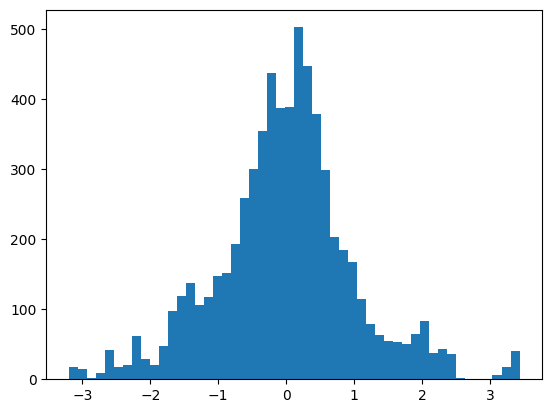

In [62]:
plt.hist(h_pred.view(-1).tolist(),50);

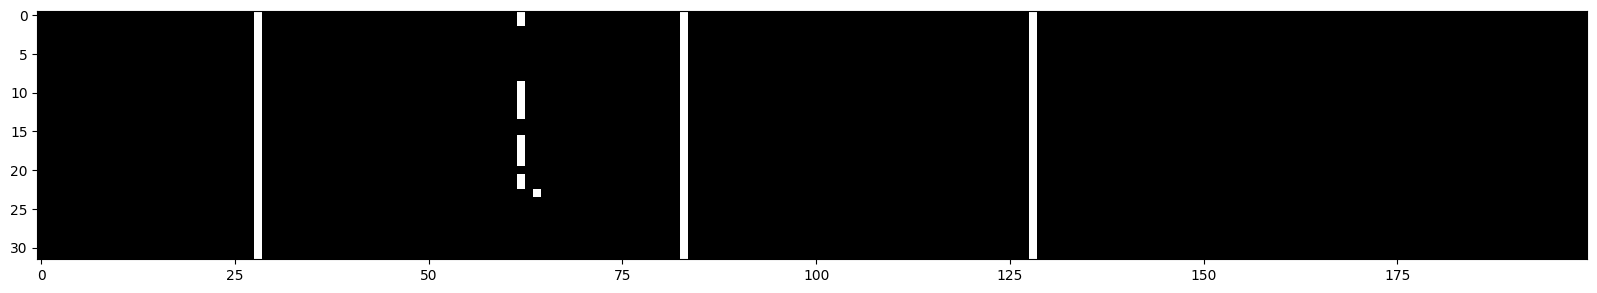

In [63]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() >0.99,cmap="gray",interpolation="nearest")

In [64]:
#iK some neurons are dead in this w.r.t the previous weight initialization we did 0.01 but its ok there should be some roughness in the network it should not always be all working but stil its better then without 

In [65]:
#so all this time what we've trying to do was normalize the data before it goes into the activation function so that it doesn't create any mess like dead neurons by preventing it to become -1.1 or 0 cause tanh(0)=0 
#the weight initialisation method is good but kinda old and has to do a lot of manuel adjustements through each layer of weight and biase as you've seen.
#but  to resolve this in 2005 a new paper was out called Batch Normalization :-https://arxiv.org/pdf/1502.03167
#in this paper they have presented a new way of normalizing the data 
#by far what we were trying to do was. we were trying to adjust the weights in such a way so that the pre_activation come out as normalized
#but in this paper they have presented a new approach in which instead of normalizing the initialized weights and biase of the network we directly initialize the pre_activation using some sets of methods
#the methods are :-
# > take the mean of pre_activation of each column of the matrix (if there is 32x200 then mean of each column wise is 1x200)(dimensions=0){sum(pre_actiavtion,keepdims=0)/no_of_neurons}
# > take the standard deviation of each column of the matrix (dimesnison=0){sqrt(((pre_activation-mean),keepdims=0)/no_of_neuron}
# > then normalize it by a formula = (pre_activation-mean)standard deviation
# #after doing all this there will be a normalised number which will be gaussian but as in this paper it is stated that we want the gaussian to move like a slider so for that we use batch_gain*normalized+batch_bias and batch_gain,batch_bias are adjusted by backprop

In [66]:
g = torch.Generator().manual_seed(2147483647)
C= torch.randn(vocab_size,n_embd)
W1 = torch.randn((n_embd*block_size,n_hidden),generator=g)*((5/3)*(2/(n_embd*block_size+n_hidden)))# the reason i did 5/3 is because its the gain as per in the table in  30
b1 = torch.randn(n_hidden,generator=g)
W2 = torch.randn(n_hidden,vocab_size,generator=g)*0.01# the reason ive put this 0.01 is to normalize all the weights so none of them is like crazy number like -17.324 so every thing will squash to 0.somefloat number and it'll be easy to backpropagate
b2 = torch.randn(vocab_size,generator=g)# the same is for bias
batch_gain = torch.ones((1,n_hidden))
batch_bias = torch.zeros((1,n_hidden))

parameters = [C,W1,b1,W2,b2,batch_bias,batch_gain]

In [67]:
for p in parameters:
    p.requires_grad=True
batch_size=32
lossi = []
for _ in range(1000):
    #creating mini-batch of the data 
    ix = torch.randint(0,xtr.shape[0],(batch_size,))
    #forward pass
    emb = C[xtr[ix]]
    h_pred =emb.view(emb.shape[0],n_embd*block_size)@W1+b1
    pre_activation = batch_gain*(h_pred-h_pred.mean(0,keepdim=True))/h_pred.std(0,keepdim=True)+batch_bias
    h = torch.tanh(pre_activation)
    logits = h@W2 +b2
    
    #backward pass
    loss = F.cross_entropy(logits,ytr[ix])
    for p in parameters:
        p.grad =None
    loss.backward()
    for p in parameters:
        p.data += -0.1*p.grad
    lossi.append(loss.log10().item())
print(f"loss : {loss.item()}")


loss : 2.8601832389831543


In [68]:
h_pred.shape

torch.Size([32, 200])

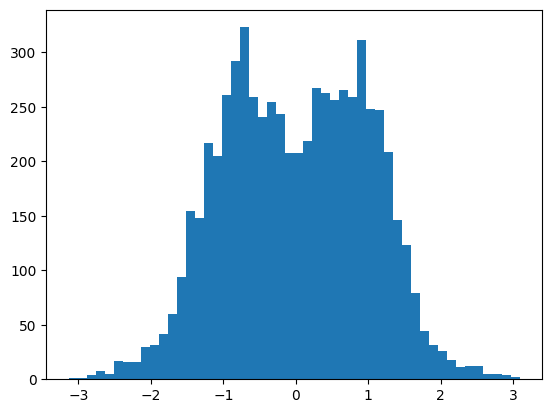

In [69]:
plt.hist(pre_activation.view(-1).tolist(),50);

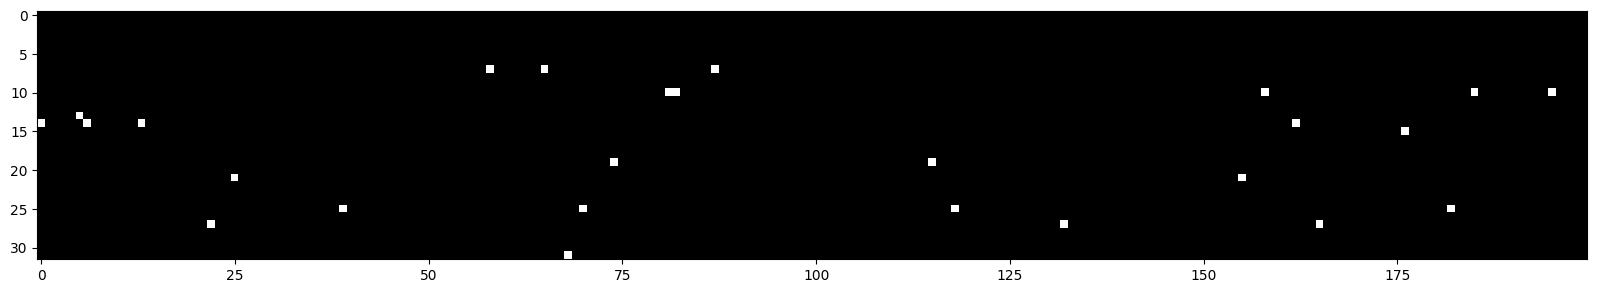

In [70]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() >0.99,cmap="gray",interpolation="nearest")

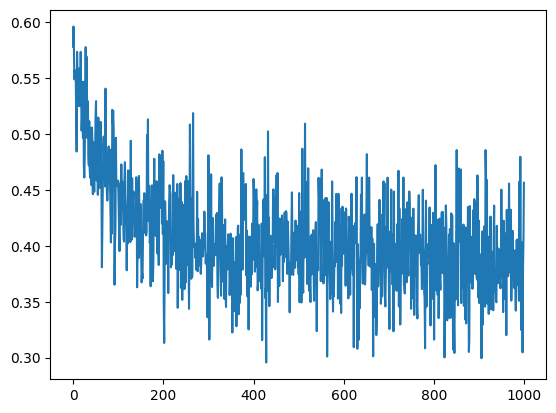

In [71]:
plt.plot(lossi)

In [72]:
#Testing the Dev/validation split 

In [73]:
#there is an issue while test and dev cause during traning we use batch normalization and in batch normalization we've use mini-batch(32) of data to find the mean and standard deviation to normalize it but during test/dev we want to send only one data and get its prediction but we cant do that cause we'll have to normalize the data and that requires batch of data to find its standard deviation and mean
#its solution is simple just use the mean and standard deviation of the whole data here's how to do that

In [74]:
with torch.no_grad():
    emb = C[xtr]
    h_pred = emb.view(emb.shape[0],n_embd*block_size)@W1+b1
    bnmean = h_pred.mean(0,keepdim=True)
    bnstd = h_pred.std(0,keepdim=True)

In [75]:
@torch.no_grad()
def split_loss(split):
    X,Y = {
        "train":(xtr,ytr),
        "dev":(xdev,ydev),
        "test":(xte,yte)
    }[split]
    emb = C[X]
    h_pred =emb.view(emb.shape[0],n_embd*block_size)@W1+b1
    pre_activation = batch_gain*(h_pred-bnmean)/bnstd +batch_bias
    h = torch.tanh(pre_activation)
    logits = h@W2 +b2
    loss = F.cross_entropy(logits,Y)
    print(split,loss.item())
split_loss("train")
split_loss("dev")

train 2.4136083126068115
dev 2.41416072845459


In [76]:
#But this way of doing it is just giving us estimate mean and standard deviation of the traning data there is a more effective way to estimate the mean and standard deviation and that consist of a method called Exponential Weighted Average 
# So what is Exponential Weighted Average ?
# it gives the average value of any predefined graphed data but it gives value or can say weightage to the previous points also so it is keeping the memory of previous points 
#so how it works ?
#> this is the formula Vt = B*(Vt-1)+(B+1)*actual_Vt
# where B is beta which is a variable which will be crucial to tell the algorithm to remember how old data to remember the value of B should be 0-1 for example if B is 0.99 then it means that the algorithm will keep the last 10 point data in mind and predict the average data by taking those points
# one more thing the more recent the data is the more value/Weitage it carries wrt to the other old data for example the 2nd last data will be more valued/Weigheted than 4th last data
#Vt-1 is the previous predicted data point
# actual_Vt is the next point as in the data or provided by the user not by the algorithm
#and the Vt it will be the predicted next point average by keeping the last 10 point in mind/memory 

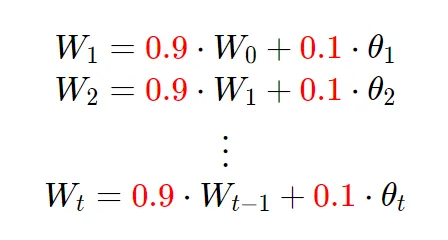

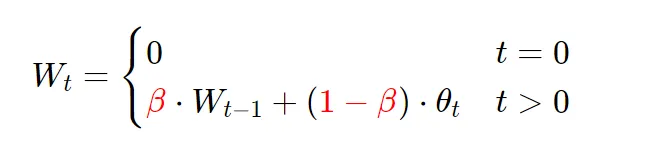

In [77]:
#Here is the image of how it gives the point average while given the data

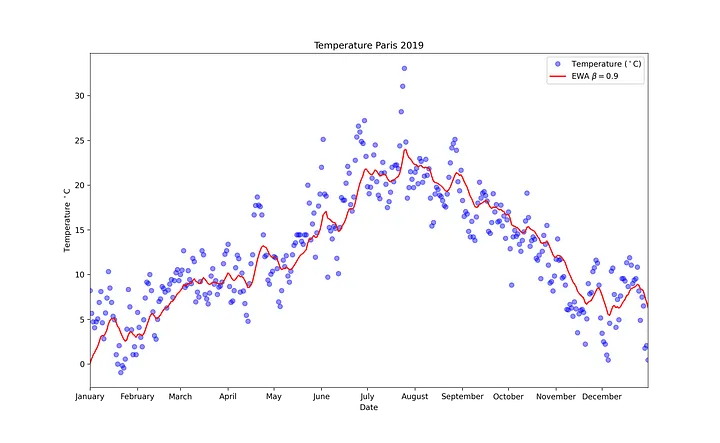

In [78]:
g = torch.Generator().manual_seed(2147483647)
C= torch.randn(vocab_size,n_embd)
W1 = torch.randn((n_embd*block_size,n_hidden),generator=g)*((5/3)*(2/(n_embd*block_size+n_hidden)))
b1 = torch.randn(n_hidden,generator=g)
W2 = torch.randn(n_hidden,vocab_size,generator=g)*0.01
b2 = torch.randn(vocab_size,generator=g)
batch_gain = torch.ones((1,n_hidden))
batch_bias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))# the reason i make it zeros cause out data is already normalized and as we know the rule of normalization that we try to make the mean =0 and standard deviation =1
bnstd_running = torch.ones((1,n_hidden))# and the reason i initialize it ones is stated in bnmean_running explaination

parameters = [C,W1,b1,W2,b2,batch_bias,batch_gain]

In [79]:
with torch.no_grad():
    emb = C[xtr]
    h_pred = emb.view(emb.shape[0],n_embd*block_size)@W1+b1
    bnmean = h_pred.mean(0,keepdim=True)
    bnstd = h_pred.std(0,keepdim=True)

In [80]:
for p in parameters:
    p.requires_grad=True
batch_size=32
lossi = []
for _ in range(1000):
    #creating mini-batch of the data 
    ix = torch.randint(0,xtr.shape[0],(batch_size,))
    #forward pass
    emb = C[xtr[ix]]
    h_pred =emb.view(emb.shape[0],n_embd*block_size)@W1+b1
    bnmean_i=h_pred.mean(0,keepdim=True)
    bnstd_i =h_pred.std(0,keepdim=True)
    pre_activation = batch_gain*(h_pred-bnmean_i)/bnstd_i+batch_bias
    with torch.no_grad():
        bnmean_running=0.999*bnmean_running+0.001*bnmean_i
        bnstd_running=0.999*bnstd_running+0.001*bnstd_i
        
    h = torch.tanh(pre_activation)
    logits = h@W2 +b2
    
    #backward pass
    loss = F.cross_entropy(logits,ytr[ix])
    for p in parameters:
        p.grad =None
    loss.backward()
    for p in parameters:
        p.data += -0.1*p.grad
    lossi.append(loss.log10().item())
print(f"loss : {loss.item()}")


loss : 2.6087186336517334


In [81]:
@torch.no_grad()
def split_loss(split):
    X,Y = {
        "train":(xtr,ytr),
        "dev":(xdev,ydev),
        "test":(xte,yte)
    }[split]
    emb = C[X]
    h_pred =emb.view(emb.shape[0],n_embd*block_size)@W1+b1
    pre_activation = batch_gain*(h_pred-bnmean_running)/bnstd_running +batch_bias
    h = torch.tanh(pre_activation)
    logits = h@W2 +b2
    loss = F.cross_entropy(logits,Y)
    print(split,loss.item())
split_loss("train")
split_loss("dev")

train 2.8693432807922363
dev 2.8639936447143555


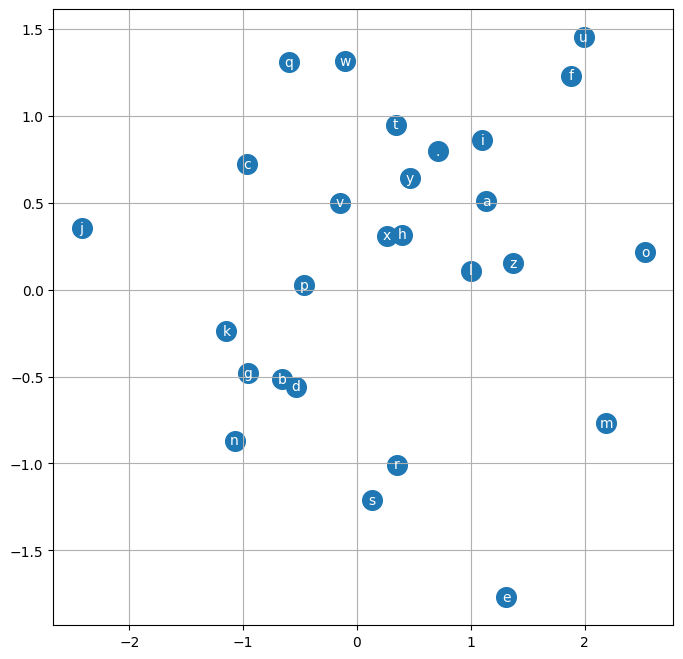

In [82]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(),int_string[i],ha="center",va="center",color="white")
plt.grid("minor")

In [83]:
#Now sampling from the model
g = torch.Generator().manual_seed(1123456789)
for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb =C[torch.tensor([context])]
        h_pred = emb.view(1,-1) @ W1+b1
        h = batch_gain*(h_pred-bnmean_running)/bnstd_running +batch_bias
        h=torch.tanh(h)
        logits = h@W2+b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()
        context =context[1:]+[ix]
        out.append(ix)
        if ix ==0:
            break
    print("".join(int_string[i]for i in out))
        

hki.
zrunlayenilxndlglltyslyn.
emirrymbny.
irlyje.
miirnnmrmilles.
xmyrn.
nbramverlwyslingletszn.
nnklsnyinlswmlkn.
menblenhliytytnkanmmselpvirlynmsycan.
cldewylsqlvarmnvfrlfn.
jymsnnlraikuntqellwrmxinrosxclhnni.
bhknjchmmisnh.
mliklrzsdrrinlietrvnt.
wldc.
tr.
aldindechlilstntynq.
mivantsyenl.
smvkr.
bljisbkyalz.
kilriixnna.
